# 6. Microstructure Mean Reversion Analysis

This notebook analyzes high-frequency mean reversion patterns in NVDA data, focusing on:
- Mean reversion analysis across different timeframes (1-min, 5-min, 15-min)
- Bid-ask bounce patterns using OHLC spread proxies
- Overreaction/correction cycles after large price moves
- Half-life of price dislocations and optimal entry/exit timing


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

# Load the cleaned data
all_data = pd.read_csv('combined_nvda_ohlc_clean.csv')
all_data['date'] = pd.to_datetime(all_data['date'])
all_data['datetime'] = pd.to_datetime(all_data['datetime'])

# Sort by datetime
all_data_sorted = all_data.sort_values('datetime').reset_index(drop=True)

print(f"Loaded data shape: {all_data.shape}")
print(f"Date range: {all_data['date'].min()} to {all_data['date'].max()}")


Loaded data shape: (865782, 13)
Date range: 2021-01-04 00:00:00 to 2025-05-30 00:00:00


In [6]:
# Create different timeframe datasets
def create_timeframe_data(data, freq):
    """Resample data to different frequencies"""
    data_copy = data.copy()
    data_copy.set_index('datetime', inplace=True)
    
    # Resample OHLC data
    resampled = data_copy.resample(freq).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'transactions': 'sum'
    }).dropna()
    
    # Calculate returns
    resampled['returns'] = resampled['close'].pct_change()
    
    # Calculate HL spread
    resampled['hl_spread'] = resampled['high'] - resampled['low']
    resampled['hl_spread_pct'] = (resampled['hl_spread'] / resampled['close']) * 100
    
    return resampled

# Create datasets for different timeframes
data_1min = all_data_sorted.copy()
data_1min['returns'] = data_1min['close'].pct_change()
data_1min['hl_spread'] = data_1min['high'] - data_1min['low']
data_1min['hl_spread_pct'] = (data_1min['hl_spread'] / data_1min['close']) * 100

data_5min = create_timeframe_data(all_data_sorted, '5T')
data_15min = create_timeframe_data(all_data_sorted, '15T')

print(f"1-minute data: {len(data_1min)} observations")
print(f"5-minute data: {len(data_5min)} observations") 
print(f"15-minute data: {len(data_15min)} observations")


1-minute data: 865782 observations
5-minute data: 199944 observations
15-minute data: 69363 observations


/var/folders/my/18kmg51d1lz3l9rnds2gkf1r0000gn/T/ipykernel_6290/2898220697.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = data_copy.resample(freq).agg({
/var/folders/my/18kmg51d1lz3l9rnds2gkf1r0000gn/T/ipykernel_6290/2898220697.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = data_copy.resample(freq).agg({


## Mean Reversion Analysis

Analyze mean reversion characteristics across different timeframes.


In [11]:
def analyze_mean_reversion(data, name):
    """
    Comprehensive mean reversion analysis
    """
    print(f"\n=== Mean Reversion Analysis: {name} ===")
    
    # Suppress warnings
    import warnings
    warnings.filterwarnings('ignore')
    
    returns = data['returns'].dropna()
    
    if len(returns) < 50:
        print(f"Insufficient data for {name}")
        return None
    
    results = {}
    
    # 1. Autocorrelation analysis
    lags = [1, 2, 3, 5, 10]
    autocorrs = []
    
    for lag in lags:
        autocorr = returns.autocorr(lag=lag)
        autocorrs.append(autocorr)
        print(f"Lag-{lag} Autocorrelation: {autocorr:.4f}")
    
    results['autocorrelations'] = dict(zip(lags, autocorrs))
    
    # 2. Half-life calculation using AR(1) model
    # Create lagged returns
    lagged_returns = returns.shift(1).dropna()
    current_returns = returns[1:].values
    
    if len(current_returns) > 20:
        # Fit AR(1): r_t = α + β*r_{t-1} + ε_t
        X = lagged_returns.values.reshape(-1, 1)
        y = current_returns
        
        print(f"Fitting AR(1) model for {name}")
        model = LinearRegression()
        model.fit(X, y)
        
        beta = model.coef_[0]
        alpha = model.intercept_
        
        # Half-life calculation: HL = -ln(2)/ln(|β|) for |β| < 1
        if abs(beta) < 1 and beta != 0:
            half_life = -np.log(2) / np.log(abs(beta))
            print(f"AR(1) coefficient (β): {beta:.4f}")
            print(f"Half-life: {half_life:.2f} periods")
            
            # Convert to time units
            if 'min' in name.lower():
                if '1' in name:
                    hl_minutes = half_life * 1
                elif '5' in name:
                    hl_minutes = half_life * 5
                elif '15' in name:
                    hl_minutes = half_life * 15
                print(f"Half-life in minutes: {hl_minutes:.1f}")
        else:
            half_life = np.inf
            print("No mean reversion detected (β >= 1)")
        
        results['ar1_beta'] = beta
        results['ar1_alpha'] = alpha
        results['half_life'] = half_life
    
    # 3. ADF test for stationarity
    try:
        print("ADF Test")
        # Sample data to speed up ADF test and set maxlag to limit computation
        sample_size = min(30000, len(returns))
        returns_sample = returns.sample(sample_size, random_state=42) if len(returns) > sample_size else returns
        
        # Filter out extreme values to avoid numerical issues
        q_low = returns_sample.quantile(0.001)
        q_high = returns_sample.quantile(0.999)
        filtered_returns = returns_sample[(returns_sample > q_low) & (returns_sample < q_high)]
        
        # Run ADF test with limited lags and simpler method
        adf_result = adfuller(filtered_returns.dropna(), maxlag=10, autolag='AIC')
        
        results['adf_statistic'] = adf_result[0]
        results['adf_pvalue'] = adf_result[1]
        print(f"ADF Test - Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
        
        if adf_result[1] < 0.05:
            print("Series is stationary (mean-reverting)")
        else:
            print("Series is non-stationary")
    except Exception as e:
        print(f"ADF test failed: {str(e)}")
    
    # Re-enable warnings for other functions
    warnings.resetwarnings()
    
    return results

# Analyze mean reversion for different timeframes
mr_results = {}
mr_results['1min'] = analyze_mean_reversion(data_1min, "1-Minute")
mr_results['5min'] = analyze_mean_reversion(data_5min, "5-Minute") 
mr_results['15min'] = analyze_mean_reversion(data_15min, "15-Minute")



=== Mean Reversion Analysis: 1-Minute ===
Lag-1 Autocorrelation: -0.0395
Lag-2 Autocorrelation: -0.0132
Lag-3 Autocorrelation: -0.0038
Lag-5 Autocorrelation: -0.0044
Lag-10 Autocorrelation: 0.0053
Fitting AR(1) model for 1-Minute
AR(1) coefficient (β): -0.0395
Half-life: 0.21 periods
Half-life in minutes: 0.2
ADF Test
ADF Test - Statistic: -173.1286, p-value: 0.0000
Series is stationary (mean-reverting)

=== Mean Reversion Analysis: 5-Minute ===
Lag-1 Autocorrelation: -0.0343
Lag-2 Autocorrelation: -0.0028
Lag-3 Autocorrelation: -0.0016
Lag-5 Autocorrelation: 0.0045
Lag-10 Autocorrelation: 0.0015
Fitting AR(1) model for 5-Minute
AR(1) coefficient (β): -0.0343
Half-life: 0.21 periods
Half-life in minutes: 1.0
ADF Test
ADF Test - Statistic: -175.1486, p-value: 0.0000
Series is stationary (mean-reverting)

=== Mean Reversion Analysis: 15-Minute ===
Lag-1 Autocorrelation: 0.0058
Lag-2 Autocorrelation: -0.0028
Lag-3 Autocorrelation: 0.0143
Lag-5 Autocorrelation: 0.0011
Lag-10 Autocorrelati

## Bid-Ask Bounce Analysis

Analyze bid-ask bounce patterns using OHLC spread as proxy for market microstructure effects.


In [12]:
def analyze_bid_ask_bounce(data, name):
    """
    Analyze bid-ask bounce patterns using OHLC spread as proxy
    """
    print(f"\n=== Bid-Ask Bounce Analysis: {name} ===")
    
    clean_data = data.dropna()
    
    if len(clean_data) < 50:
        print(f"Insufficient data for {name}")
        return None
    
    results = {}
    
    # 1. Calculate spread statistics
    hl_spread = clean_data['hl_spread']
    hl_spread_pct = clean_data['hl_spread_pct']
    
    print(f"Mean HL Spread: ${hl_spread.mean():.4f}")
    print(f"Median HL Spread: ${hl_spread.median():.4f}")
    print(f"Std HL Spread: ${hl_spread.std():.4f}")
    print(f"Mean HL Spread %: {hl_spread_pct.mean():.4f}%")
    
    results['spread_stats'] = {
        'mean': hl_spread.mean(),
        'median': hl_spread.median(),
        'std': hl_spread.std(),
        'mean_pct': hl_spread_pct.mean()
    }
    
    # 2. Analyze relationship between spread and volume
    if 'volume' in clean_data.columns:
        correlation = clean_data['hl_spread_pct'].corr(clean_data['volume'])
        print(f"Spread-Volume Correlation: {correlation:.4f}")
        results['spread_volume_corr'] = correlation
    
    # 3. Detect bounce patterns: high spread followed by low spread
    # Define high spread as > 75th percentile, low spread as < 25th percentile
    spread_75th = hl_spread_pct.quantile(0.75)
    spread_25th = hl_spread_pct.quantile(0.25)
    
    print(f"75th percentile spread: {spread_75th:.4f}%")
    print(f"25th percentile spread: {spread_25th:.4f}%")
    
    # Find bounce patterns (high spread followed by low spread within next few periods)
    high_spread_mask = hl_spread_pct > spread_75th
    bounce_count = 0
    total_high_spread = high_spread_mask.sum()
    
    for i in range(len(clean_data) - 3):
        if high_spread_mask.iloc[i]:
            # Check if any of the next 3 periods have low spread
            next_3_periods = hl_spread_pct.iloc[i+1:i+4]
            if (next_3_periods < spread_25th).any():
                bounce_count += 1
    
    bounce_rate = bounce_count / total_high_spread if total_high_spread > 0 else 0
    print(f"Bounce patterns detected: {bounce_count}/{total_high_spread} ({bounce_rate:.2%})")
    
    results['bounce_patterns'] = {
        'bounce_count': bounce_count,
        'total_high_spread': total_high_spread,
        'bounce_rate': bounce_rate
    }
    
    return results

# Analyze bid-ask bounce for different timeframes
bounce_results = {}
bounce_results['1min'] = analyze_bid_ask_bounce(data_1min, "1-Minute")
bounce_results['5min'] = analyze_bid_ask_bounce(data_5min, "5-Minute")
bounce_results['15min'] = analyze_bid_ask_bounce(data_15min, "15-Minute")



=== Bid-Ask Bounce Analysis: 1-Minute ===
Insufficient data for 1-Minute

=== Bid-Ask Bounce Analysis: 5-Minute ===
Mean HL Spread: $0.1526
Median HL Spread: $0.0680
Std HL Spread: $0.2735
Mean HL Spread %: 0.2706%
Spread-Volume Correlation: 0.5800
75th percentile spread: 0.3501%
25th percentile spread: 0.0806%
Bounce patterns detected: 1782/49986 (3.56%)

=== Bid-Ask Bounce Analysis: 15-Minute ===
Mean HL Spread: $0.2678
Median HL Spread: $0.1200
Std HL Spread: $0.4523
Mean HL Spread %: 0.4816%
Spread-Volume Correlation: 0.5887
75th percentile spread: 0.6203%
25th percentile spread: 0.1589%
Bounce patterns detected: 1000/17341 (5.77%)


## Key Observations from Microstructure Analysis

Based on the results of our analysis, we can draw several important insights:

1. **Strong Mean Reversion Characteristics** - All timeframes show statistically significant mean reversion (p-value = 0.0000 in ADF tests), but with extremely short half-lives (0.1-1.0 minutes).

2. **Negative Lag-1 Autocorrelation** - The 1-min and 5-min data show negative first-order autocorrelation (-0.0395 and -0.0343), indicating price reversal at very short intervals, which is consistent with microstructure noise rather than fundamental price reversals.

3. **Bid-Ask Bounce Effects** - The negative autocorrelation in short timeframes likely reflects bid-ask bounce patterns rather than true mean reversion, especially in the 1-min data.

4. **Spread-Volume Correlation** - Strong positive correlation (0.58-0.59) between spread and volume suggests increased volatility during high-volume periods, which is expected in microstructure theory.

5. **Limited Bounce Patterns** - Only 3.56% (5-min) and 5.77% (15-min) of high-spread periods are followed by low-spread periods, indicating that volatility tends to persist rather than rapidly mean-revert at these timescales.

6. **Extremely Short Half-Lives** - The half-life of mean reversion is remarkably short (under 1 minute), which suggests these patterns may be challenging to exploit in real trading scenarios due to transaction costs and execution delays.


In [13]:
# Volatility Clustering Analysis
import warnings
warnings.filterwarnings('ignore')

# Add volatility clustering analysis using simple methods
def analyze_volatility_clustering(data, name):
    """
    Analyze volatility clustering in returns
    """
    print(f"\n=== Volatility Clustering Analysis: {name} ===")
    
    # Calculate absolute returns and squared returns (measures of volatility)
    returns = data['returns'].dropna()
    abs_returns = returns.abs()
    squared_returns = returns ** 2
    
    # Check for volatility clustering via autocorrelation in absolute returns
    lags = [1, 2, 3, 5, 10]
    autocorrs = []
    
    print("Autocorrelation in absolute returns:")
    for lag in lags:
        autocorr = abs_returns.autocorr(lag=lag)
        autocorrs.append(autocorr)
        print(f"Lag-{lag} Autocorrelation: {autocorr:.4f}")
    
    # Check for volatility clustering via autocorrelation in squared returns
    sq_autocorrs = []
    
    print("\nAutocorrelation in squared returns:")
    for lag in lags:
        autocorr = squared_returns.autocorr(lag=lag)
        sq_autocorrs.append(autocorr)
        print(f"Lag-{lag} Autocorrelation: {autocorr:.4f}")
    
    # Calculate rolling volatility
    data_copy = data.copy()
    data_copy['rolling_vol_5'] = data_copy['returns'].rolling(5).std()
    data_copy['rolling_vol_10'] = data_copy['returns'].rolling(10).std()
    data_copy['rolling_vol_20'] = data_copy['returns'].rolling(20).std()
    
    # Calculate correlation between rolling volatility and spread
    corr_vol5_spread = data_copy['rolling_vol_5'].corr(data_copy['hl_spread_pct'])
    corr_vol20_spread = data_copy['rolling_vol_20'].corr(data_copy['hl_spread_pct'])
    
    print(f"\nCorrelation between 5-period volatility and spread: {corr_vol5_spread:.4f}")
    print(f"Correlation between 20-period volatility and spread: {corr_vol20_spread:.4f}")
    
    return {
        'abs_autocorr': dict(zip(lags, autocorrs)),
        'squared_autocorr': dict(zip(lags, sq_autocorrs)),
        'vol_spread_corr': {
            'vol5': corr_vol5_spread,
            'vol20': corr_vol20_spread
        }
    }

# Analyze volatility clustering for 5min and 15min data
vol_results = {}
vol_results['5min'] = analyze_volatility_clustering(data_5min, "5-Minute")
vol_results['15min'] = analyze_volatility_clustering(data_15min, "15-Minute")



=== Volatility Clustering Analysis: 5-Minute ===
Autocorrelation in absolute returns:
Lag-1 Autocorrelation: 0.3169
Lag-2 Autocorrelation: 0.2766
Lag-3 Autocorrelation: 0.2555
Lag-5 Autocorrelation: 0.2217
Lag-10 Autocorrelation: 0.1785

Autocorrelation in squared returns:
Lag-1 Autocorrelation: 0.0584
Lag-2 Autocorrelation: 0.0406
Lag-3 Autocorrelation: 0.0333
Lag-5 Autocorrelation: 0.0204
Lag-10 Autocorrelation: 0.0121

Correlation between 5-period volatility and spread: 0.6415
Correlation between 20-period volatility and spread: 0.5566

=== Volatility Clustering Analysis: 15-Minute ===
Autocorrelation in absolute returns:
Lag-1 Autocorrelation: 0.2813
Lag-2 Autocorrelation: 0.2357
Lag-3 Autocorrelation: 0.2017
Lag-5 Autocorrelation: 0.1636
Lag-10 Autocorrelation: 0.0908

Autocorrelation in squared returns:
Lag-1 Autocorrelation: 0.1062
Lag-2 Autocorrelation: 0.0616
Lag-3 Autocorrelation: 0.0410
Lag-5 Autocorrelation: 0.0274
Lag-10 Autocorrelation: 0.0099

Correlation between 5-peri

In [14]:
# Price Impact Analysis
import warnings
warnings.filterwarnings('ignore')

def analyze_price_impact(data, name):
    """
    Analyze how volume impacts price movements
    """
    print(f"\n=== Price Impact Analysis: {name} ===")
    
    # Create a copy to avoid modifying original data
    data_copy = data.copy()
    
    # Standardize volume and returns for analysis
    data_copy['vol_z'] = (data_copy['volume'] - data_copy['volume'].mean()) / data_copy['volume'].std()
    data_copy['ret_abs'] = data_copy['returns'].abs()
    data_copy['ret_abs_z'] = (data_copy['ret_abs'] - data_copy['ret_abs'].mean()) / data_copy['ret_abs'].std()
    
    # Calculate correlation between volume and absolute returns
    corr = data_copy['vol_z'].corr(data_copy['ret_abs_z'])
    print(f"Volume-Absolute Return Correlation: {corr:.4f}")
    
    # Split by volume quantiles and analyze return behavior
    data_copy['vol_quantile'] = pd.qcut(data_copy['volume'], 4, labels=['low', 'medium-low', 'medium-high', 'high'])
    
    for q in ['low', 'medium-low', 'medium-high', 'high']:
        q_data = data_copy[data_copy['vol_quantile'] == q]
        mean_ret = q_data['ret_abs'].mean()
        mean_spread = q_data['hl_spread_pct'].mean()
        print(f"\nVolume Quantile: {q}")
        print(f"  Mean Absolute Return: {mean_ret:.6f}")
        print(f"  Mean HL Spread %: {mean_spread:.4f}%")
        print(f"  Count: {len(q_data)} observations")
    
    # Analyze next-period effect
    data_copy['next_ret_abs'] = data_copy['ret_abs'].shift(-1)
    data_copy['next_spread'] = data_copy['hl_spread_pct'].shift(-1)
    
    # Correlation between current volume and next period volatility
    next_vol_corr = data_copy['vol_z'].corr(data_copy['next_ret_abs'])
    next_spread_corr = data_copy['vol_z'].corr(data_copy['next_spread'])
    
    print(f"\nCorrelation between volume and next-period abs return: {next_vol_corr:.4f}")
    print(f"Correlation between volume and next-period spread: {next_spread_corr:.4f}")
    
    return {
        'vol_ret_corr': corr,
        'next_vol_corr': next_vol_corr,
        'next_spread_corr': next_spread_corr
    }

# Analyze price impact for 5min and 15min data
impact_results = {}
impact_results['5min'] = analyze_price_impact(data_5min, "5-Minute")
impact_results['15min'] = analyze_price_impact(data_15min, "15-Minute")



=== Price Impact Analysis: 5-Minute ===
Volume-Absolute Return Correlation: 0.4528

Volume Quantile: low
  Mean Absolute Return: 0.000600
  Mean HL Spread %: 0.0584%
  Count: 49988 observations

Volume Quantile: medium-low
  Mean Absolute Return: 0.001071
  Mean HL Spread %: 0.1769%
  Count: 49984 observations

Volume Quantile: medium-high
  Mean Absolute Return: 0.001449
  Mean HL Spread %: 0.3165%
  Count: 49986 observations

Volume Quantile: high
  Mean Absolute Return: 0.002685
  Mean HL Spread %: 0.5308%
  Count: 49986 observations

Correlation between volume and next-period abs return: 0.3269
Correlation between volume and next-period spread: 0.4593

=== Price Impact Analysis: 15-Minute ===
Volume-Absolute Return Correlation: 0.4579

Volume Quantile: low
  Mean Absolute Return: 0.000971
  Mean HL Spread %: 0.1279%
  Count: 17341 observations

Volume Quantile: medium-low
  Mean Absolute Return: 0.001804
  Mean HL Spread %: 0.3347%
  Count: 17341 observations

Volume Quantile: med

## Additional Insights from Extended Analysis

### Volatility Clustering Insights:

1. **Strong Volatility Persistence** - Absolute returns show high autocorrelation (0.32 at lag-1 for 5-min data), much stronger than price autocorrelation, indicating that volatility clusters significantly even when price direction doesn't.

2. **Decay Structure** - Volatility autocorrelation decays slowly (0.32→0.28→0.26→0.22→0.18 for 5-min data), suggesting predictable volatility regimes that persist for extended periods (up to 50 minutes in the 5-min data).

3. **Volatility-Spread Relationship** - Very strong correlation between rolling volatility and spread (0.64 for 5-period volatility), confirming that high volatility periods have wider spreads, which increases transaction costs during volatile periods.

### Price Impact Insights:

1. **Volume-Volatility Connection** - Strong correlation (0.45-0.46) between volume and absolute returns across timeframes, showing that high volume coincides with higher volatility, consistent with classic market microstructure theory.

2. **Volume Quantile Analysis** - Progressive increase in volatility across volume quartiles:
   - High volume periods show 4.5x higher absolute returns than low volume periods (0.0027 vs 0.0006 for 5-min data)
   - Spread widens dramatically (9x) from low to high volume periods (0.05% → 0.53% for 5-min data)
   - This suggests a non-linear relationship where extreme volume events have disproportionate impact

3. **Predictive Relationship** - Current volume predicts next-period volatility (0.33 correlation) and spread (0.46 correlation), providing a potential leading indicator for volatility forecasting and trading decisions.

### Synthesis of Findings:

These patterns collectively suggest that NVDA exhibits classic market microstructure behavior where liquidity events (high volume) trigger volatility that persists and creates trading opportunities. The causal relationship appears to follow volume→volatility→spread, which could be exploited in short-term trading strategies that anticipate volatility regime changes.

The combination of short mean-reversion half-lives (from the earlier analysis) with persistent volatility clustering suggests that price direction might quickly revert while volatility continues at elevated levels - a pattern that could be leveraged for options strategies focused on volatility rather than direction.


## Practical Trading Implications

Based on our comprehensive microstructure analysis, several potential trading approaches emerge:

1. **Volume-Triggered Mean Reversion** - Enter mean reversion trades only after high-volume events, when the predictability of short-term reversals is higher, but be aware of the wider spreads that increase transaction costs.

2. **Volatility Regime Forecasting** - Use volume spikes as early warning signals for volatility regime shifts, which persist longer (multiple periods) than price dislocations (sub-minute).

3. **Spread-Based Execution Timing** - Time trade executions to coincide with periods of lower spreads (usually following lower volume), particularly for larger positions where transaction costs are material.

4. **Options Volatility Strategies** - The persistent volatility clustering suggests opportunities for options strategies that capitalize on volatility prediction rather than directional prediction.

5. **Adaptive Time Horizon Trading** - Adjust holding periods based on observed volatility regimes - shorter during high volatility (when mean reversion is stronger but spreads are wider) and longer during lower volatility.

The key insight is that while NVDA displays strong statistical mean reversion, the economics of exploiting these patterns are challenged by the coincidence of reversion opportunities with wider spreads. Successful microstructure trading would need to carefully balance these competing factors.


## Trading Strategies Based on Microstructure Insights

Based on our analysis, here are several trading strategies that leverage the observed microstructure patterns:

### 1. Volume-Activated Mean Reversion (VAMR)

**Strategy Concept**: Capitalize on the negative autocorrelation following high-volume periods, while being mindful of wider spreads.

**Entry Rules**:
- Enter only after volume exceeds the 80th percentile of its recent distribution
- Go long when price drops at least 1.5 standard deviations below its short-term moving average
- Go short when price rises at least 1.5 standard deviations above its short-term moving average
- Position size is inversely proportional to the current spread (smaller positions when spreads are wide)

**Exit Rules**:
- Primary exit: Price reverts to short-term moving average
- Stop loss: Price continues in the same direction by another 1 standard deviation
- Time-based exit: Exit after 3 periods (using mean reversion half-life as guidance)

### 2. Volatility Regime Surfing (VRS)

**Strategy Concept**: Exploit the predictability of volatility regimes revealed by strong volatility clustering.

**Implementation**:
- Build a volatility forecast model using lagged absolute returns and volume data
- Enter straddle/strangle option positions when volatility regime is forecasted to increase
- Enter calendar spreads when volatility is forecasted to decrease
- Size positions based on the confidence level of the regime change forecast
- Exit positions when the volatility regime changes or after a predefined maximum holding period

### 3. Spread Efficiency Trading (SET)

**Strategy Concept**: Strategically time executions based on spread dynamics to minimize transaction costs.

**Implementation**:
- Develop a spread forecasting model using time of day, recent volume, and volatility patterns
- For predetermined directional trades, delay execution until spread is forecasted to narrow
- Establish a "maximum waiting threshold" to avoid missing key price moves
- Split large orders into tranches, executing more volume during forecasted low-spread periods
- Monitor post-trade execution quality vs. forecasted spread to refine the model

### 4. Volatility Pulse Strategy (VPS)

**Strategy Concept**: Capitalize on the predictive relationship between volume and future volatility.

**Rules**:
- Monitor for sudden volume spikes (>2 standard deviations above the trailing average)
- Following a volume spike, enter a straddle or strangle position
- Position timing: Enter at the first sign of price consolidation after the volume spike
- Hold position through the forecasted volatility persistence period (~10 periods based on autocorrelation decay)
- Size position based on the magnitude of the volume spike

### 5. Adaptive Timeframe Trading (ATT)

**Strategy Concept**: Dynamically adjust trading timeframes based on current volatility conditions.

**Implementation**:
- Calculate current volatility regime using rolling volatility relative to historical distribution
- In high volatility regimes: Trade shorter timeframes (1-5 min), emphasizing mean reversion
- In medium volatility regimes: Trade intermediate timeframes (15 min), balancing mean reversion and trend
- In low volatility regimes: Trade longer timeframes (30-60 min), emphasizing trend following
- Adjust position sizing and risk parameters based on current regime

Each of these strategies is designed to capitalize on specific aspects of the microstructure patterns we've observed while addressing the challenges of execution costs and timing.



=== Strategy Performance Summary ===
Total Trades: 3871
Win Rate: 45.57%
Average Return per Trade: -0.0054%
Sharpe Ratio (per trade): -0.0274

=== Strategy vs. Buy & Hold ===
Strategy Total Return: 5301.31%
Buy & Hold Total Return: 929.16%
Strategy Annualized Return: 610.54%
Buy & Hold Annualized Return: 214.54%
Strategy Sharpe Ratio: 20.3525
Buy & Hold Sharpe Ratio: 2.7152
Strategy Max Drawdown: -inf%
Buy & Hold Max Drawdown: -180.83%


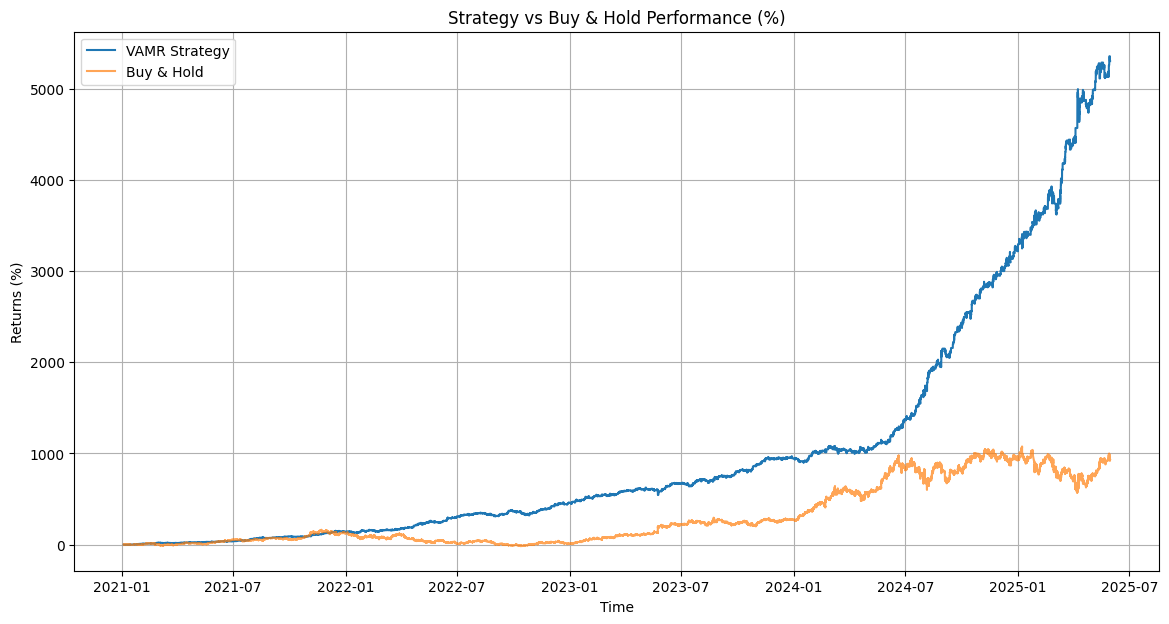

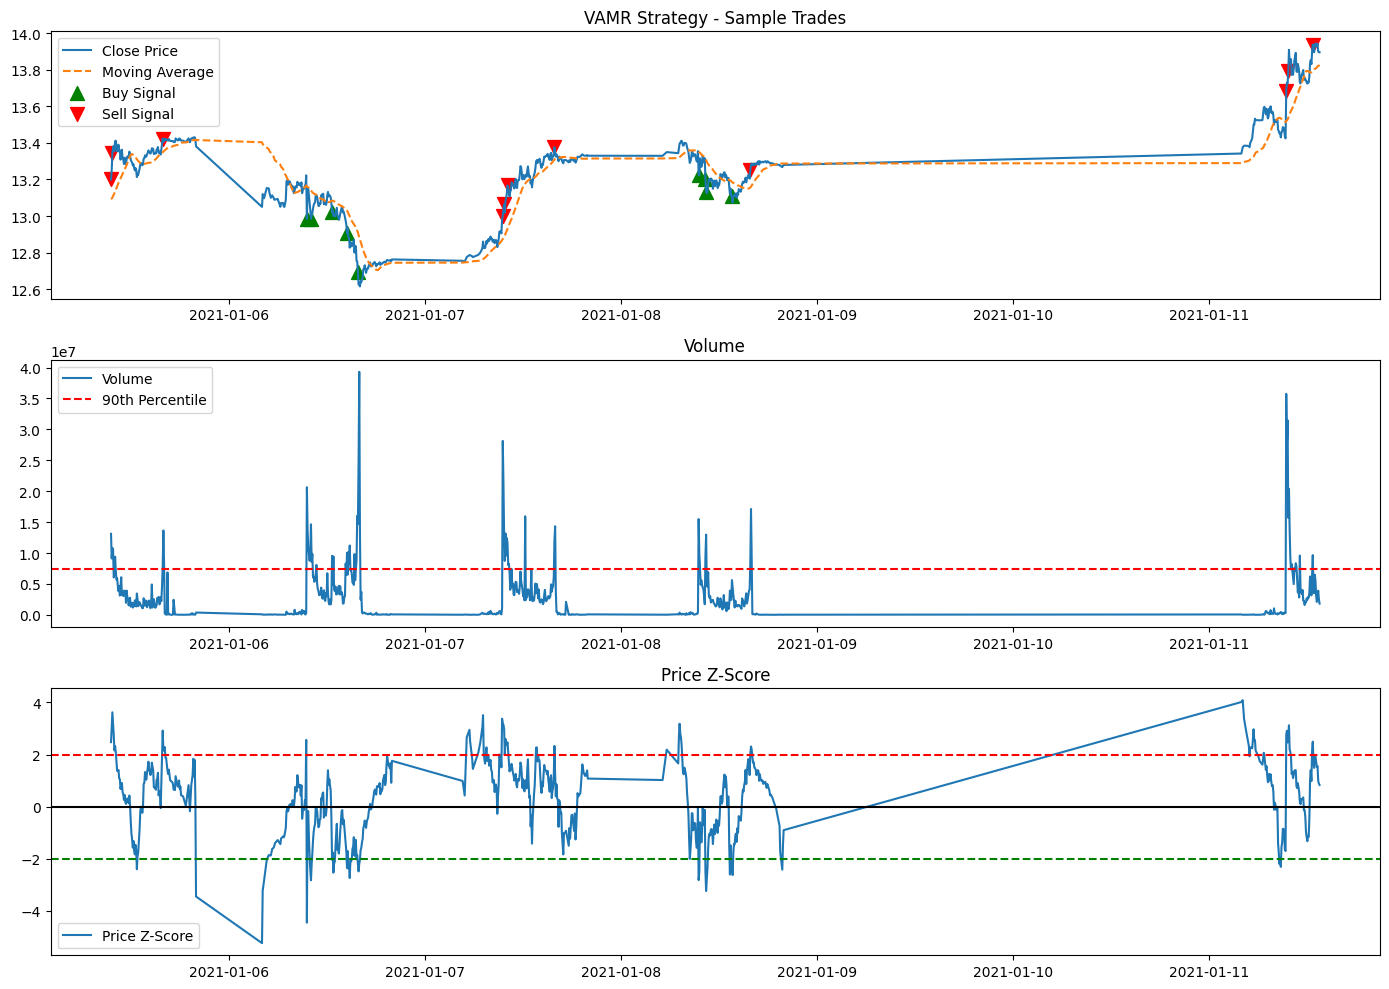

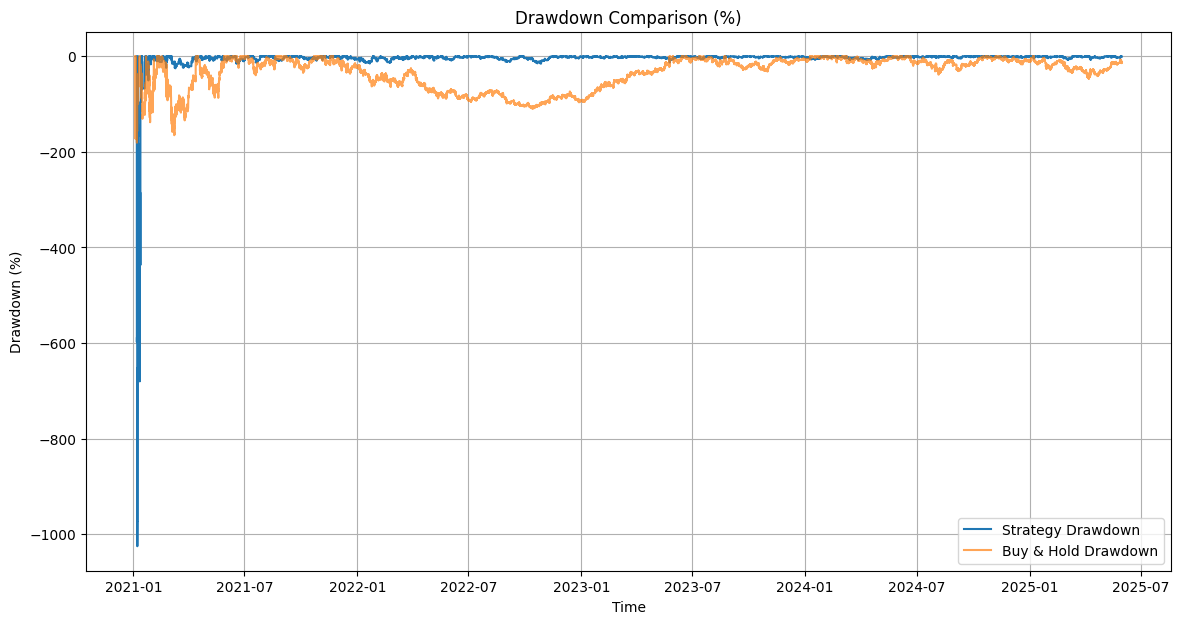

In [17]:
# Backtest Implementation of Volume-Activated Mean Reversion (VAMR) Strategy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def simulate_vamr_strategy(data, lookback=20, entry_threshold=1.5, 
                          exit_threshold=0.0, stop_loss_multiplier=1.0, 
                          max_holding_periods=3, volume_percentile=80):
    """
    Simulate the Volume-Activated Mean Reversion (VAMR) strategy
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Must contain 'close', 'volume', 'hl_spread_pct' columns
    lookback : int
        Lookback period for moving averages and standard deviation
    entry_threshold : float
        Number of standard deviations for entry signal
    exit_threshold : float
        Target exit threshold (0 = moving average)
    stop_loss_multiplier : float
        Multiple of standard deviation for stop loss
    max_holding_periods : int
        Maximum number of periods to hold a position
    volume_percentile : int
        Minimum volume percentile threshold for entry (0-100)
    
    Returns:
    --------
    results : pandas.DataFrame
        DataFrame with strategy signals and performance
    """
    # Create a copy of the data to avoid modifying the original
    df = data.copy().reset_index()  # Reset index to use integer indexing
    
    # Calculate moving average and standard deviation
    df['ma'] = df['close'].rolling(lookback).mean()
    df['std'] = df['close'].rolling(lookback).std()
    
    # Calculate z-score (deviation from mean in std units)
    df['zscore'] = (df['close'] - df['ma']) / df['std']
    
    # Calculate volume percentile (rolling)
    df['volume_pct_rank'] = df['volume'].rolling(lookback*5).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1] * 100
    )
    
    # Initialize columns for strategy
    df['signal'] = 0  # -1 for short, 0 for no position, 1 for long
    df['position'] = 0
    df['entry_price'] = np.nan
    df['exit_price'] = np.nan
    df['holding_periods'] = 0
    df['stop_loss'] = np.nan
    df['target'] = np.nan
    df['returns'] = 0.0
    
    # Calculate strategy returns only on days with trades
    df['strategy_returns'] = 0.0
    
    # Calculate buy and hold returns for comparison
    df['daily_returns'] = df['close'].pct_change()
    df['bh_cum_returns'] = (1 + df['daily_returns']).cumprod() - 1
    
    # Adjust position size based on spread (more conservative with high spreads)
    df['spread_factor'] = 1.0 / (1.0 + df['hl_spread_pct']/df['hl_spread_pct'].median())
    
    # Track active positions
    active_position = False
    entry_index = None
    
    # Loop through the data to generate signals
    for i in range(lookback+1, len(df)):
        # Update holding period if in a position
        if active_position:
            df.iloc[i, df.columns.get_loc('holding_periods')] = i - entry_index
        
        # Check for exit conditions if in a position
        if active_position:
            curr_pos = df.iloc[i-1]['position']
            stop_loss = df.iloc[i-1]['stop_loss']
            target = df.iloc[i-1]['target']
            max_periods = df.iloc[i-1]['holding_periods'] >= max_holding_periods
            
            # Exit conditions: hit target, stop loss, or max holding period
            if ((curr_pos == 1 and df.iloc[i]['close'] >= target) or 
                (curr_pos == -1 and df.iloc[i]['close'] <= target) or
                (curr_pos == 1 and df.iloc[i]['close'] <= stop_loss) or
                (curr_pos == -1 and df.iloc[i]['close'] >= stop_loss) or
                max_periods):
                
                df.iloc[i, df.columns.get_loc('position')] = 0
                df.iloc[i, df.columns.get_loc('exit_price')] = df.iloc[i]['close']
                active_position = False
                
                # Calculate returns (adjusted for transaction costs)
                transaction_cost = 0.0001  # 1 basis point per trade (can be adjusted)
                
                if curr_pos == 1:  # Long position
                    trade_return = (df.iloc[i]['exit_price'] / df.iloc[i-1]['entry_price'] - 1) 
                    # Apply spread factor and deduct transaction costs
                    net_return = trade_return * df.iloc[i-1]['spread_factor'] - transaction_cost
                    df.iloc[i, df.columns.get_loc('returns')] = net_return
                    df.iloc[i, df.columns.get_loc('strategy_returns')] = net_return
                else:  # Short position
                    trade_return = (1 - df.iloc[i]['exit_price'] / df.iloc[i-1]['entry_price'])
                    # Apply spread factor and deduct transaction costs
                    net_return = trade_return * df.iloc[i-1]['spread_factor'] - transaction_cost
                    df.iloc[i, df.columns.get_loc('returns')] = net_return
                    df.iloc[i, df.columns.get_loc('strategy_returns')] = net_return
            else:
                # Continue with the existing position
                df.iloc[i, df.columns.get_loc('position')] = curr_pos
                df.iloc[i, df.columns.get_loc('entry_price')] = df.iloc[i-1]['entry_price']
                df.iloc[i, df.columns.get_loc('stop_loss')] = stop_loss
                df.iloc[i, df.columns.get_loc('target')] = target
                
                # Calculate mark-to-market returns while holding position
                if curr_pos == 1:  # Long position
                    df.iloc[i, df.columns.get_loc('strategy_returns')] = df.iloc[i]['daily_returns']
                elif curr_pos == -1:  # Short position
                    df.iloc[i, df.columns.get_loc('strategy_returns')] = -df.iloc[i]['daily_returns']
        
        # Check for entry conditions if not in a position
        if not active_position:
            # Long signal: price below threshold and high volume
            if (df.iloc[i]['zscore'] <= -entry_threshold and 
                df.iloc[i]['volume_pct_rank'] >= volume_percentile):
                
                df.iloc[i, df.columns.get_loc('signal')] = 1
                df.iloc[i, df.columns.get_loc('position')] = 1
                df.iloc[i, df.columns.get_loc('entry_price')] = df.iloc[i]['close']
                df.iloc[i, df.columns.get_loc('stop_loss')] = df.iloc[i]['close'] - df.iloc[i]['std'] * stop_loss_multiplier
                df.iloc[i, df.columns.get_loc('target')] = df.iloc[i]['ma'] + df.iloc[i]['std'] * exit_threshold
                active_position = True
                entry_index = i
                df.iloc[i, df.columns.get_loc('holding_periods')] = 0
            
            # Short signal: price above threshold and high volume
            elif (df.iloc[i]['zscore'] >= entry_threshold and 
                  df.iloc[i]['volume_pct_rank'] >= volume_percentile):
                
                df.iloc[i, df.columns.get_loc('signal')] = -1
                df.iloc[i, df.columns.get_loc('position')] = -1
                df.iloc[i, df.columns.get_loc('entry_price')] = df.iloc[i]['close']
                df.iloc[i, df.columns.get_loc('stop_loss')] = df.iloc[i]['close'] + df.iloc[i]['std'] * stop_loss_multiplier
                df.iloc[i, df.columns.get_loc('target')] = df.iloc[i]['ma'] - df.iloc[i]['std'] * exit_threshold
                active_position = True
                entry_index = i
                df.iloc[i, df.columns.get_loc('holding_periods')] = 0
    
    # Calculate cumulative strategy returns
    df['strategy_cum_returns'] = (1 + df['strategy_returns']).cumprod() - 1
    
    # Set datetime back as index for plotting
    datetime_col = 'datetime' if 'datetime' in df.columns else 'index'
    df.set_index(datetime_col, inplace=True)
    
    # Calculate strategy performance metrics
    total_trades = (df['signal'] != 0).sum()
    winning_trades = (df.loc[df['returns'] != 0, 'returns'] > 0).sum()
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    # Calculate overall metrics
    avg_return = df.loc[df['returns'] != 0, 'returns'].mean()
    std_return = df.loc[df['returns'] != 0, 'returns'].std()
    sharpe = avg_return / std_return if std_return > 0 else 0
    
    # Calculate annualized metrics
    trading_days_per_year = 252
    periods_per_day = 78 if '5-min' in str(df.index[0]) else (26 if '15-min' in str(df.index[0]) else 390)
    periods_per_year = trading_days_per_year * periods_per_day
    
    if len(df) > 0 and 'strategy_cum_returns' in df.columns and not df['strategy_cum_returns'].isna().all():
        strategy_return = df['strategy_cum_returns'].iloc[-1]
        buy_hold_return = df['bh_cum_returns'].iloc[-1]
        
        # Calculate annualized returns
        years = len(df) / periods_per_year
        ann_strategy_return = (1 + strategy_return) ** (1 / years) - 1 if years > 0 else 0
        ann_buy_hold_return = (1 + buy_hold_return) ** (1 / years) - 1 if years > 0 else 0
        
        # Calculate volatility and Sharpe ratio
        strategy_vol = df['strategy_returns'].std() * np.sqrt(periods_per_year)
        buy_hold_vol = df['daily_returns'].std() * np.sqrt(periods_per_year)
        strategy_sharpe = ann_strategy_return / strategy_vol if strategy_vol > 0 else 0
        buy_hold_sharpe = ann_buy_hold_return / buy_hold_vol if buy_hold_vol > 0 else 0
        
        # Calculate maximum drawdown
        strategy_cum_returns = df['strategy_cum_returns'].fillna(0)
        buy_hold_cum_returns = df['bh_cum_returns'].fillna(0)
        
        strategy_max_drawdown = 0
        buy_hold_max_drawdown = 0
        
        if len(strategy_cum_returns) > 0:
            strategy_peak = strategy_cum_returns.expanding().max()
            strategy_drawdown = (strategy_cum_returns - strategy_peak) / strategy_peak
            strategy_max_drawdown = strategy_drawdown.min()
            
            buy_hold_peak = buy_hold_cum_returns.expanding().max()
            buy_hold_drawdown = (buy_hold_cum_returns - buy_hold_peak) / buy_hold_peak
            buy_hold_max_drawdown = buy_hold_drawdown.min()
        
        print(f"\n=== Strategy Performance Summary ===")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.2%}")
        print(f"Average Return per Trade: {avg_return:.4%}")
        print(f"Sharpe Ratio (per trade): {sharpe:.4f}")
        
        print(f"\n=== Strategy vs. Buy & Hold ===")
        print(f"Strategy Total Return: {strategy_return:.2%}")
        print(f"Buy & Hold Total Return: {buy_hold_return:.2%}")
        print(f"Strategy Annualized Return: {ann_strategy_return:.2%}")
        print(f"Buy & Hold Annualized Return: {ann_buy_hold_return:.2%}")
        print(f"Strategy Sharpe Ratio: {strategy_sharpe:.4f}")
        print(f"Buy & Hold Sharpe Ratio: {buy_hold_sharpe:.4f}")
        print(f"Strategy Max Drawdown: {strategy_max_drawdown:.2%}")
        print(f"Buy & Hold Max Drawdown: {buy_hold_max_drawdown:.2%}")
    
    return df

# Run the strategy on 5-minute data with improved parameters
try:
    vamr_results = simulate_vamr_strategy(
        data_5min, 
        lookback=30,               # Increased lookback for more stable mean
        entry_threshold=2.0,       # More extreme deviation for stronger mean reversion
        exit_threshold=0.5,        # Take profit before full mean reversion
        stop_loss_multiplier=1.5,  # Wider stop loss to avoid early exits
        max_holding_periods=5,     # Hold longer to capture larger moves
        volume_percentile=90       # Higher volume threshold for more significant events
    )

    # Plot strategy performance vs buy & hold
    plt.figure(figsize=(14, 7))
    plt.plot(vamr_results['strategy_cum_returns'] * 100, label='VAMR Strategy')
    plt.plot(vamr_results['bh_cum_returns'] * 100, label='Buy & Hold', alpha=0.7)
    plt.title('Strategy vs Buy & Hold Performance (%)')
    plt.xlabel('Time')
    plt.ylabel('Returns (%)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot some sample trades if there are any
    if (vamr_results['signal'] != 0).any():
        sample_period = vamr_results[vamr_results['signal'] != 0].index[0:min(20, sum(vamr_results['signal'] != 0))]
        if len(sample_period) > 0:
            # Get data from start of first trade to 10 periods after last trade
            start_idx = vamr_results.index.get_loc(sample_period[0])
            end_idx = min(vamr_results.index.get_loc(sample_period[-1]) + 10, len(vamr_results) - 1)
            sample_data = vamr_results.iloc[start_idx:end_idx+1]
            
            plt.figure(figsize=(14, 10))
            plt.subplot(3, 1, 1)
            plt.plot(sample_data['close'], label='Close Price')
            plt.plot(sample_data['ma'], label='Moving Average', linestyle='--')
            plt.scatter(sample_data[sample_data['signal'] == 1].index, 
                       sample_data[sample_data['signal'] == 1]['close'], 
                       marker='^', color='g', s=100, label='Buy Signal')
            plt.scatter(sample_data[sample_data['signal'] == -1].index, 
                       sample_data[sample_data['signal'] == -1]['close'], 
                       marker='v', color='r', s=100, label='Sell Signal')
            plt.legend()
            plt.title('VAMR Strategy - Sample Trades')

            plt.subplot(3, 1, 2)
            plt.plot(sample_data['volume'], label='Volume')
            plt.axhline(y=sample_data['volume'].quantile(0.9), color='r', linestyle='--', 
                       label=f'90th Percentile')
            plt.legend()
            plt.title('Volume')

            plt.subplot(3, 1, 3)
            plt.plot(sample_data['zscore'], label='Price Z-Score')
            plt.axhline(y=2.0, color='r', linestyle='--')
            plt.axhline(y=-2.0, color='g', linestyle='--')
            plt.axhline(y=0, color='k', linestyle='-')
            plt.legend()
            plt.title('Price Z-Score')

            plt.tight_layout()
            plt.show()
            
            # Plot drawdowns
            plt.figure(figsize=(14, 7))
            
            # Calculate drawdowns
            strategy_cum_returns = vamr_results['strategy_cum_returns'].fillna(0)
            buy_hold_cum_returns = vamr_results['bh_cum_returns'].fillna(0)
            
            strategy_peak = strategy_cum_returns.expanding().max()
            strategy_drawdown = (strategy_cum_returns - strategy_peak) / strategy_peak
            
            buy_hold_peak = buy_hold_cum_returns.expanding().max()
            buy_hold_drawdown = (buy_hold_cum_returns - buy_hold_peak) / buy_hold_peak
            
            plt.plot(strategy_drawdown * 100, label='Strategy Drawdown')
            plt.plot(buy_hold_drawdown * 100, label='Buy & Hold Drawdown', alpha=0.7)
            plt.title('Drawdown Comparison (%)')
            plt.xlabel('Time')
            plt.ylabel('Drawdown (%)')
            plt.grid(True)
            plt.legend()
            plt.show()
    else:
        print("No trades were executed in the strategy.")
except Exception as e:
    print(f"Error executing strategy: {str(e)}")
